In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt

from astropy import units 
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as mw
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, HernquistPotential
from galpy.util.bovy_coords import rect_to_cyl, rect_to_cyl_vec
from galpy.potential import DehnenSmoothWrapperPotential
from galpy.potential import ChandrasekharDynamicalFrictionForce
from galpy.potential import MovingObjectPotential
satellite_gal = Orbit.from_name('MWsatellitegalaxies') #list of satellite galaxies of Milky Way 
name_satellite_gal = satellite_gal.name
#%matplotlib notebook

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [2]:
# Function plots orbit (integrated backwards) of given satellite galaxy of the Milky Way Galaxy
def plot_satgalorbit(sat_galaxy, name_sat, xaxis_dim, yaxis_dim):
    # Input:
    # sat_galaxy = orbit object 
    # x and y axis dimensions to plot in 
    # name_sat: string of the satellite galaxy's name
    # Output: 
    # returns the plot of given orbit object 
    
    ts = numpy.linspace(0.,-10.,1000)*units.Gyr
    sat_galaxy.integrate(ts, mw)
    plot = sat_galaxy.plot(d1 = xaxis_dim, d2 = yaxis_dim)
    plt.title('Orbit of Satellite Galaxy: '+ name_sat)
    plt.show()
    plt.close()
    return plot


# Function plots orbits of satellite galaxy taking dynamical friction effects into account
def plot_satgalorbit_cdf(sat_galaxy, name_sat, xaxis_dim, yaxis_dim, sat_mass, sat_size):
    # Input:
    # sat_galaxy = orbit object 
    # x and y axis dimensions to plot in (strings)
    # mass and size of satellite to model dynamical friction effects (quantities with units attached)
    # name_sat: string of the satellite galaxy's name
    # Output: 
    # returns the plot of given orbit object 
    
    ts = numpy.linspace(0.,-10.,1000)*units.Gyr
    cdf= ChandrasekharDynamicalFrictionForce(GMs=sat_mass, rhm = sat_size ,dens=mw)
    sat_galaxy.integrate(ts, mw+cdf)
    plot = sat_galaxy.plot(d1 = xaxis_dim, d2 = yaxis_dim)
    plt.title('Orbit of Satellite Galaxy: '+ name_sat + ' Including Dynamical Friction')
    plt.show()
    plt.close()
    return plot

# Function plots orbits of satellite galaxy as well as a star cluster within the satellite galaxy - simulates accretion onto MW
def plot_sat_cluster(sat_galaxy, name_sat, sat_potential, xaxis_dim, yaxis_dim, sat_mass, sat_size, x_satgal, y_satgal, z_satgal,
                     vx_satgal,vy_satgal, vz_satgal, tform, tsteady):
    # Input:
    # sat_galaxy: an orbit object for a given satellite galaxy of the MW
    # name_sat: string of the satellite galaxy's name
    # sat_potential: potential object modelling the satellite's potential
    # x and y axis dimensions to plot in (strings)
    # x_satgal, y_satgal, z_satgal: x,y,z positions of the star_cluster within the satellite galaxy's frame of reference
    # vx_satgal, vy_satgal, vz_satgal: x,y,z velocities of the star_cluster within the satellite galaxy's frame of reference
    # mass and size of satellite to model dynamical friction effects (quantities with units attached)
    # tform, tsteady: parameters of the potential, models tidal disruption of satellite galaxy (quantities with units attached)
    # Output: 
    # Position and velocity of cluster at end time 
    # Orbit object of satellite galaxy
    # Dynamical Friction Force (cdf)
    
    t_back = 10.
    ts = numpy.linspace(0.,-t_back,1000)*units.Gyr
    cdf= ChandrasekharDynamicalFrictionForce(GMs=sat_mass, rhm = sat_size ,dens=mw)
    sat_galaxy.integrate(ts, mw+cdf)
    R_sat = sat_galaxy.R(-t_back*units.Gyr)  #cylindrical radius at time t
    vR_sat = sat_galaxy.vR(-t_back*units.Gyr) #radial velocity at time t 
    vT_sat = sat_galaxy.vT(-t_back*units.Gyr) #tangential velocity at time t 
    z_sat = sat_galaxy.z(-t_back*units.Gyr) #vertical height at time t
    vz_sat = sat_galaxy.vz(-t_back*units.Gyr) #vertical velocity at time t 
    phi_sat = sat_galaxy.phi(-t_back*units.Gyr) #azimuth at time t 
    # Rectangular coordinates and velocities
    coord = [sat_galaxy.x(-t_back*units.Gyr), sat_galaxy.y(-t_back*units.Gyr), sat_galaxy.z(-t_back*units.Gyr)]
    vcoord = [sat_galaxy.vx(-t_back*units.Gyr),sat_galaxy.vy(-t_back*units.Gyr),sat_galaxy.vz(-t_back*units.Gyr)]
    
    t_fwrd = 15.
    ts_f= numpy.linspace(-t_back, -t_back+t_fwrd, 1000)*units.Gyr
    #sat_galaxy = Orbit(vxvv = [R_sat, vR_sat, vT_sat, z_sat, vz_sat, phi_sat],ro = 8., vo=220.)
    sat_galaxy = sat_galaxy(-t_back*units.Gyr)
    sat_galaxy.integrate(ts_f, mw + cdf)
    plt.figure(figsize=(10.,8.))
    #%matplotlib notebook
    sat_galaxy.plot(d1 =  xaxis_dim, d2= yaxis_dim,linestyle = ':', color = 'black', label = 'satellite') #plots orbit of the satellite galaxy in MW frame of reference
    
    #sat_pot = HernquistPotential(amp = 2*sat_mass, a = sat_size, ro = 8., vo=220.)
    sat_movingpot = MovingObjectPotential(sat_galaxy, sat_potential)

    # Transform from satellite galaxy's frame of reference to Milky Way Galaxy's frame of reference (using Cartesian coordinates)
    # Rectangular coordinates of the star cluster in galactocentric frame
    x_gal = coord[0] + x_satgal
    y_gal = coord[1] + y_satgal
    z_gal = coord[2] + z_satgal
    # Velocity of the star cluster in galactocentric frame
    vx_gal = vcoord[0] + vx_satgal
    vy_gal = vcoord[1] + vy_satgal
    vz_gal = vcoord[2] + vz_satgal
    # Transform to cylindrical coordinate system: R, phi, z 
    R, phi, z = rect_to_cyl(x_gal, y_gal, z_gal)
    vR, vT, vz = rect_to_cyl_vec(vx_gal, vy_gal, vz_gal,x_gal, y_gal, z_gal, cyl = False)
    
    # initialize star cluster on orbit inside satellite galaxy
    star_cluster = Orbit(vxvv = [R,vR,vT,z,vz,phi],ro = 8., vo=220.)
    star_cluster.integrate(ts_f, mw + sat_movingpot)
    star_cluster.plot(d1 =  xaxis_dim, d2= yaxis_dim, linestyle = '-', overplot = True, color = 'blue', alpha=0.6, label = 'star cluster') #plots orbit of the star_cluster in MW frame of reference
    plt.title('Orbit of Star Cluster Within Satellite Galaxy: ' + name_sat + ' in Galactocentric Frame')
    plt.legend()
    plt.show()
    #plt.close()
    
    # !! Determine orbit of the star_cluster within the satellite galaxy as it spirals into MW:
    # subtract motion of sat galaxy from star_cluster's motion !!

    # Implement wrapper potential to simulate tidal disruption of satellite galaxy
    plt.figure(figsize=(12.,10.))
    #%matplotlib notebook
    tstart = tform - 5.*units.Gyr
    tend = tform + 5.*units.Gyr 
    time_int = numpy.linspace(tstart.to_value(units.Gyr), tend.to_value(units.Gyr), 1000)*units.Gyr
    
    if tstart < -t_back*units.Gyr:
            # re-integrate satellite galaxy from current time back to tstart 
            re_time = numpy.linspace(-t_back, tstart.to_value(units.Gyr), 1000)*units.Gyr
            sat_galaxy.integrate(re_time, mw+cdf)
            
            # initialize star cluster on orbit in satellite galaxy at time tstart:
            # Rectangular coordinates and velocities
            coord = [sat_galaxy.x(tstart), sat_galaxy.y(tstart), sat_galaxy.z(tstart)]
            vcoord = [sat_galaxy.vx(tstart),sat_galaxy.vy(tstart),sat_galaxy.vz(tstart)]

            # Transform from satellite galaxy's frame of reference to Milky Way Galaxy's frame of reference (using Cartesian coordinates)
            # Rectangular coordinates of the star cluster in galactocentric frame
            x_gal = coord[0] + x_satgal
            y_gal = coord[1] + y_satgal
            z_gal = coord[2] + z_satgal
            # Velocity of the star cluster in galactocentric frame
            vx_gal = vcoord[0] + vx_satgal
            vy_gal = vcoord[1] + vy_satgal
            vz_gal = vcoord[2] + vz_satgal
            # Transform to cylindrical coordinate system: R, phi, z 
            R, phi, z = rect_to_cyl(x_gal, y_gal, z_gal)
            vR, vT, vz = rect_to_cyl_vec(vx_gal, vy_gal, vz_gal,x_gal, y_gal, z_gal, cyl = False)
            
            # Re-initialize star cluster on orbit at time tstart
            star_cluster = Orbit(vxvv=[R,vR,vT,vz,z,phi], ro=8., vo=220.)
    else:
            # default: star cluster is initialized at -10Gyr in given satellite galaxy
            star_cluster = star_cluster(tstart)
    
    
    
    sat_galaxy = sat_galaxy(tstart) #make copy of sat_galaxy orbit at time tstart 
    sat_galaxy.integrate(time_int, mw+cdf) # integrate sat_galaxy forward for 10Gyrs
    sat_galaxy.plot(d1 =  xaxis_dim, d2= yaxis_dim,linestyle = ':', color = 'black', label = 'satellite galaxy')
    sat_movingpot = MovingObjectPotential(sat_galaxy, sat_potential)
    dswp = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot, tform=tform, tsteady=tsteady, decay = True)
    star_cluster.integrate(time_int, mw+dswp) 
        # star cluster in combined potential: MW galaxy & moving potential of satellite galaxy 
    star_cluster.plot(d1 =  xaxis_dim, d2= yaxis_dim, linestyle = '-', overplot = True, color = 'blue', alpha = 0.6,\
                      label = 'star cluster') 
        #plots orbit of the star_cluster in MW frame of reference
    plt.legend()
    plt.title('Orbit of Star Cluster Within Satellite Galaxy for Tform = ' + str(tform) + ' & Tsteady = ' + str(tsteady) + ' (in Galactocentric Frame)')
    plt.savefig('WrapperPotential-Decaying Mass.pdf')
    plt.show()
    #plt.close()
    
    # Figure out where star cluster is at end of integration: at tend 
    end_pos_cluster = [star_cluster.R(tend),star_cluster.vR(tend),star_cluster.vT(tend),star_cluster.z(tend),star_cluster.vz(tend), star_cluster.phi(tend)]
            # [R,vT,vT,z,vz,phi]
    end_pos_gal = [sat_galaxy.R(tend),sat_galaxy.vR(tend),sat_galaxy.vT(tend),sat_galaxy.z(tend),sat_galaxy.vz(tend), sat_galaxy.phi(tend)]

    '''
    # Used for finding dswp when integrating satellite galaxy backward in previous version of code
    time_intb = numpy.linspace(tend.to_value(units.Gyr), tstart.to_value(units.Gyr), 1000)*units.Gyr
    star_cluster_b = Orbit(vxvv = end_pos_cluster, ro=8., vo =220.) #full 6 coordinates
    sat_galaxy_b = Orbit(vxvv=end_pos_gal, ro=8., vo =220.)
    sat_galaxy_b.integrate(time_intb, mw + cdf)
    sat_galaxy_b.plot(d1 =  xaxis_dim, d2= yaxis_dim,linestyle = ':', color = 'black', label = 'satellite galaxy')
    sat_movingpot_b = MovingObjectPotential(sat_galaxy_b, sat_potential)
    #new_tform = tform - end_t
    #dswp_back = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot_b, tform=tform, tsteady=tsteady, decay = True)
    star_cluster_b.integrate(time_intb, mw + dswp) # star cluster is in combined potential of MW galaxy and the moving potential of satellite galaxy 
    star_cluster_b.plot(d1 =  xaxis_dim, d2= yaxis_dim, linestyle = '-', overplot = True, color = 'blue', alpha = 0.6,\
                      label = 'star cluster') # galactocentric radius as a function of time
    plt.legend()
    plt.title('Orbit of Star Cluster Within Satellite Galaxy for Tform = ' + str(tform) + ' & Tsteady = ' + str(tsteady) + ' (in Galactocentric Frame)')
    plt.show()
    plt.close()
    '''
    
    '''
    # Directly compare plots of satellite galaxy and star clusters from forward and backwards integration
    sat_galaxy.plot(d1='t',d2='r', color = 'pink', label='forward')
    sat_galaxy_b.plot(d1='t',d2='r', linestyle=':', color ='black', overplot=True, label='backward')
    plt.legend()
    plt.title('Comparing integrated orbit of satellite galaxy: '+ name)
    plt.show()
    plt.close()
    
    star_cluster.plot(d1='t',d2='r', color = 'pink', label='forward')
    star_cluster_b.plot(d1='t',d2='r', linestyle=':', color ='black', overplot=True, label='backward')
    plt.legend()
    plt.title('Comparing integrated orbit of globular cluster')
    plt.show()
    plt.close()
    
    '''
    
    return end_pos_cluster,end_pos_gal, dswp, cdf




TucanaIII
35.25509518429917 km / s


<Figure size 720x576 with 0 Axes>

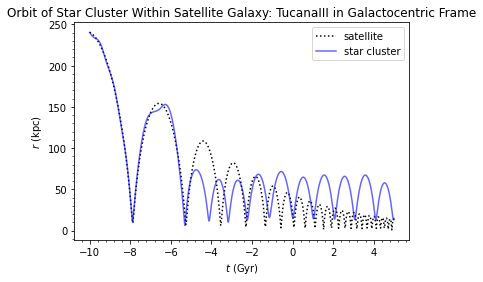

<Figure size 864x720 with 0 Axes>

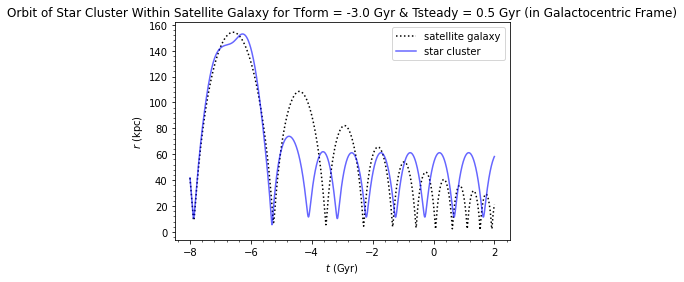

In [3]:
index = 35
sat = satellite_gal[index]
name = name_satellite_gal[index]
print(name)
Msat = 10.**11.*units.Msun
size = 1.05*(Msat/(10.**8./1*units.Msun))**0.5*units.kpc
potential = HernquistPotential(amp = 2*Msat, a = size, ro = 8., vo=220.)
x,y,z = 4*units.kpc, 0*units.kpc, 0*units.kpc
vcirc = potential.vcirc(4*units.kpc)
vx, vy, vz = 0.*units.km/units.s, vcirc, 0.*units.km/units.s
print(vcirc)
tform, tsteady = -3.*units.Gyr, 0.5*units.Gyr
end_pos_cluster, end_pos_gal,dswp, cdf = plot_sat_cluster(sat, name, potential, 't', 'r', Msat, size, x,y,z,vx,vy,vz, tform, tsteady)


## Trying out Streamspraydf:

In [4]:
from galpy.df import streamdf
from streamtools.df import streamspraydf

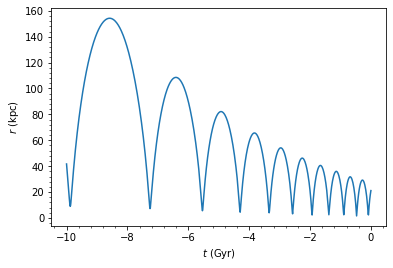

In [5]:
from galpy.potential import LogarithmicHaloPotential

cluster_mass = 2e4*units.Msun
cluster_orbit = Orbit(vxvv=end_pos_cluster, ro=8., vo=220.)
cluster_orbit.turn_physical_off()

lp= LogarithmicHaloPotential(normalize=1.,q=0.9)

# Integrate orbit of star cluster (progenitor) both forwards and backwards for 2 Gyr
ts = numpy.linspace(0.,1., 1000)*units.Gyr
cluster_orbit.integrate(ts, mw)
cluster_orbitb = cluster_orbit()
cluster_orbitb.turn_physical_off()
cluster_orbitb.integrate(-ts, mw)


# Re-integrate orbit of sat galaxy to match disruption time and re-implement moving potential to model satellite galaxy
ts = numpy.linspace(0., -10., 1000)*units.Gyr
sat_galaxy = Orbit(vxvv=end_pos_gal)
sat_galaxy.integrate(ts, mw + cdf)
sat_galaxy.plot(d1='t',d2='r')
sat_movingpot = MovingObjectPotential(sat_galaxy, potential)
tform = -5*units.Gyr
dswp = DehnenSmoothWrapperPotential(amp=1.0, pot = sat_movingpot, tform=tform, tsteady=tsteady, decay = True)


# Model leading part of the stream
spdf= streamspraydf(cluster_mass,progenitor=cluster_orbit,pot=dswp+mw, rtpot=mw, leading=True, tdisrupt=10.*units.Gyr)
# Model trailing part of the tidal stream
spdft= streamspraydf(cluster_mass,progenitor=cluster_orbit,pot=dswp+mw, rtpot=mw, leading=False,tdisrupt=10.*units.Gyr)


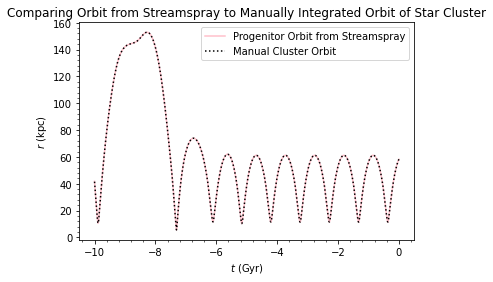

In [6]:
import copy
o = copy.deepcopy(spdf._progenitor)
#orbit = spdf._progenitor.plot(d1='t',d2='r')
o.turn_physical_on()
o.plot(d1='t',d2='r', color = 'pink', label= 'Progenitor Orbit from Streamspray')

ts = numpy.linspace(0.,-10.,1000)*units.Gyr
cluster_o = Orbit(vxvv=end_pos_cluster, ro=8., vo=220.)
cluster_o.integrate(ts, dswp+mw)
cluster_o.plot(d1='t',d2='r',linestyle = ':', overplot = True, color = 'black', label='Manual Cluster Orbit')
plt.legend()
plt.title('Comparing Orbit from Streamspray to Manually Integrated Orbit of Star Cluster')
plt.show()
plt.close()

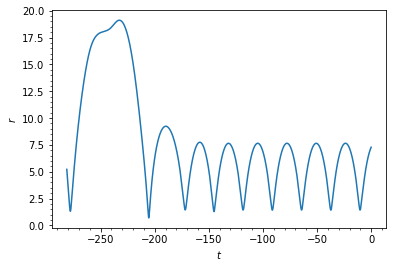

In [7]:
orbit = spdf._progenitor.plot(d1='t',d2='r')

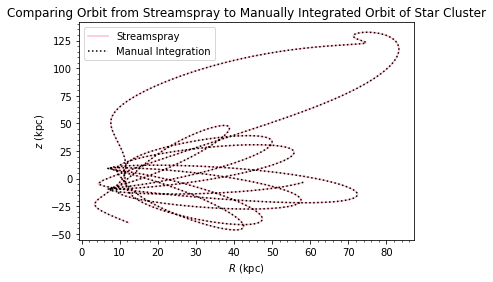

In [11]:
o.plot(color = 'pink', label='Streamspray')
cluster_o.plot(linestyle=':', color='black',overplot=True, label='Manual Integration')
plt.title('Comparing Orbit from Streamspray to Manually Integrated Orbit of Star Cluster')
plt.legend()

<Figure size 864x720 with 0 Axes>

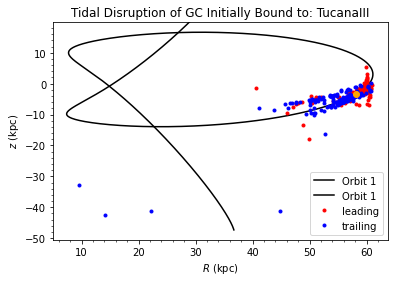

In [10]:
# Plot orbit of progenitor
plt.figure(figsize=(12.,10.))
cluster_orbit.turn_physical_on()
cluster_orbitb.turn_physical_on()
cluster_orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
cluster_orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

# Return: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
RvRt,dt= spdft.sample(n=300,returndt=True,integrate=True)
# Convert from natural units to physical units
d = 8.
plt.plot(RvR[0]*d,RvR[3]*d,'r.', label = 'leading')
plt.plot(RvRt[0]*d,RvRt[3]*d,'b.', label = 'trailing')
plt.plot(cluster_orbit.R(),cluster_orbit.z(),'o', color='orange')
plt.legend()

plt.title('Tidal Disruption of GC Initially Bound to: ' + name)
plt.show()
plt.close()



In [ ]:
from astropy.constants import kpc
# Plot tidal streams using colormap to identify the stripping times of stars and where they are on the stream now

# Plot orbit of progenitor
plt.figure(figsize=(16.,10.))
cluster_orbit.turn_physical_on()
cluster_orbitb.turn_physical_on()
cluster_orbit.plot(d1 = 'R', d2 = 'z', color = 'k')
cluster_orbitb.plot(d1 = 'R', d2 = 'z', color = 'k', overplot=True)

# Plot tidal streams
# spdf.sample returns: (R,vR,vT,z,vz,phi) of sampled points on the stream in 6,N array
RvR,dt= spdf.sample(n=300,returndt=True,integrate=True)
RvRt,dtt= spdft.sample(n=300,returndt=True,integrate=True)

# Implement colormap and colorscale using dt
v=220.
sec_in_Gyr = 3.16e16
t_Gyr= (d*kpc.to_value(units.m))/(v*1e3)/sec_in_Gyr #converts from natural units to Gyr
amp = dt*t_Gyr
plt.scatter(RvR[0]*d,RvR[3]*d, label = 'leading', c=amp, cmap = 'Reds' )
plt.colorbar(label='Time Since Stripping (Gyr)')
amp = dtt*t_Gyr
plt.scatter(RvRt[0]*d,RvRt[3]*d, label = 'trailing', c=amp, cmap = 'Blues' )
plt.colorbar()
plt.plot(cluster_orbit.R(),cluster_orbit.z(),'o', color='orange')
#plt.legend()
plt.xlim(40, 70)
plt.ylim(-20,10)
label='tidalstreams:'+str(name)+'.pdf'
plt.title('Tidal Disruption of GC Initially Bound to: ' + name)
plt.savefig(label)
plt.show()
plt.close()

Trying out unit conversions from astropy:

In [12]:
from astropy.constants import kpc
8*units.kpc
kpc.to_value(units.m)

3.0856775814671917e+19

from galpy.util import bovy_conversion
